Last updated: February 10, 2025

This project was originally done in April 2022 and was originally a group project by the three of us:
- [Iris Lew](https://www.linkedin.com/in/iris-lew/)
- [Rebecca Sun](https://www.linkedin.com/in/rebeccasun3/)
- [Ben Meier](https://www.linkedin.com/in/meierbenjamin/)

We were tasked to do an exploratory data analysis (EDA). While the overall structure and some of the analysis is the same, I've redone the writeup, code, and updated the analysis in October-December 2022. In June 2024, I added in the regression discontinuity design for additional analysis. In February 2025, I added in the analysis for the unincorporated areas only.

This notebook is split into three parts:

1.   EDA
2.   Analysis on the Full Dataset
3.   Analysis on the Unincorporated Areas Only



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_001_LATrafficCollisions/LA_Traffic_Collisions_1_EDA.ipynb)


# LA Traffic Collisions EDA

We were interested in the examining whether Los Angeles's Vision Zero project could be considered a success. LA is infamous for its traffic and bad drivers. In 2015, Mayor Eric Garcetti wanted to end all traffic related deaths. [“Vision Zero is a strategy to eliminate all traffic fatalities and severe injuries, while increasing safe, healthy, equitable mobility for all.”](https://visionzeronetwork.org/about/what-is-vision-zero/) There are different sources of its goals on whether it is by 2025 in LA in general (source by [lacity.gov](https://lacity.gov/highlights/take-vision-zero-pledge-create-safer-streets)) or if it is only in unincorporated County roadways by 2035 (source by [pw.lacounty.gov](https://pw.lacounty.gov/visionzero/)). I split the analysis so that there is one set for LA in general and one specifically for the unincorporated areas.

To analyze LA Traffic Collisions and possible effects under Vision Zero, I downloaded the data from [LA City's public datasets](https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w). The data I had originally downloaded was from 2022-03-26 at 11:57 PDT.

## Setup

I set up the necessary libraries to import the data, do the analysis, and create plots.

In [ ]:
### delete when done
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
!pip install rdrobust

In [ ]:
# Import modules
from copy import deepcopy
from matplotlib import ticker

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import folium
from IPython.display import HTML
from folium.plugins import HeatMap

pd.set_option('display.max_columns', None)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from rdrobust import rdrobust, rdbwselect, rdplot

import geopandas as gpd
from shapely.geometry import Point

In [ ]:
filename = r'Traffic_Collision_Data_from_2010_to_Present.csv'
dat = pd.read_csv(filename)

dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572594 entries, 0 to 572593
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DR Number               572594 non-null  int64  
 1   Date Reported           572594 non-null  object 
 2   Date Occurred           572594 non-null  object 
 3   Time Occurred           572594 non-null  int64  
 4   Area ID                 572594 non-null  int64  
 5   Area Name               572594 non-null  object 
 6   Reporting District      572594 non-null  int64  
 7   Crime Code              572594 non-null  int64  
 8   Crime Code Description  572594 non-null  object 
 9   MO Codes                485596 non-null  object 
 10  Victim Age              489109 non-null  float64
 11  Victim Sex              563393 non-null  object 
 12  Victim Descent          562496 non-null  object 
 13  Premise Code            571632 non-null  float64
 14  Premise Description 

In [ ]:
dat.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)"
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)"
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)"
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)"
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)"


Renaming the columns with snake casing and lower case.

In [ ]:
dat.columns = dat.columns.str.replace(" ","_").str.lower()
dat.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)"
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)"
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)"
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)"
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)"


In [ ]:
dat.shape

(572594, 18)

The MO Codes are 4 digit numbers, and their corresponding defintions can be found in a PDF at the same link to download the [dataset](https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w). This PDF was converted into a UTF-8 csv file through an external software. Once it was in UTF-8, I read it in using pandas `read_csv` function like above.

I replaced the column names to be more understandable and zero-filled in the code column because the codes in the traffic collision dataset were consistently of length 4.

In [ ]:
mo_codes_dict = pd.read_csv("MO_CODES_utf8.csv", header=None)
mo_codes_dict.drop(2, axis=1, inplace=True)
mo_codes_dict.columns = ["mo_code", "code_def"]

#zero fill the mo_codes so it will be a better join with the rest of the dataset.
mo_codes_dict.mo_code = mo_codes_dict.mo_code.astype(str).str.zfill(4)
mo_codes_dict.head()

,mo_code,code_def
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


## Column Exploration
In data exploration, the next step is to look at each of the individual columns. I used the data dictionary also provided in the link where I downloaded the data from. There were a few topics I could look at together: date/time, location, codes, and victim information.

* Division of Records Number
    * dr_number
* Date/Time:
    * date_reported
    * date_occurred
    * time_occurred
* Location:
    * area_id
    * area_name
    * reporting_district
    * premise_code
    * premise_description
    * address
    * cross_street
    * location
* Code:
    * crime_code
    * crime_code_description
    * mo_codes
* Victim Information
    * victim_age
    * victim_sex
    * victim_descent

### Division of Records number

According to LA's dataset website, the `dr_number` is "Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits." Thus, I expect this to be unique and of a uniform length.

In [ ]:
dat.dr_number.astype(str).value_counts().sort_values(ascending=False) #unique

,count
dr_number,
190319651,1
190413978,1
190514836,1
190514762,1
190514716,1
...,...
220306049,1
220505617,1
221805667,1


In [ ]:
dat.dr_number.astype(str).map(len).value_counts()

,count
dr_number,
9,572594


Since this is a unique number, I will use `dr_number` **as the index and primary key.**

The definition provided by the codebook indicates that `dr_number` has some relationship with dates and the `area_id` so I decided to cross-check the column with `date_occurred`, `date_reported`, and`area_id`. I find that there are some mismatches, but there wasn't anything systematic at first glance, so it is likely a typo.

In [ ]:
print(sum(dat["dr_number"].astype("str").str[:2]!=dat["date_occurred"].astype("str").str[-2:]))
print(sum(dat["dr_number"].astype("str").str[:2]!=dat["date_reported"].astype("str").str[-2:]))
dat[dat["dr_number"].astype("str").str[:2]!=dat["date_reported"].astype("str").str[-2:]].head(5)

3896
1066


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
7047,191613917,09/12/2018,09/12/2018,1651,16,Foothill,1651,997,TRAFFIC COLLISION,3004 3028 3030 3037 3101 3401 3701 4016,37.0,F,H,101.0,STREET,GOLDEN STATE,OSBORNE ST,"(34.2455, -118.4177)"
12817,180418940,01/07/2019,12/31/2018,1300,4,Hollenbeck,403,997,TRAFFIC COLLISION,3101 3401 3701 3004 3025 3029,34.0,M,F,101.0,STREET,GRIFFIN,MONTECITO,"(34.0953, -118.2019)"
14281,190814307,08/17/2018,08/17/2018,1135,8,West LA,827,997,TRAFFIC COLLISION,3004 3028 3030 3035 3036 3101 3401 3701 4008,28.0,M,W,101.0,STREET,BEVERLY CT,SUNSET BL,"(34.0638, -118.4703)"
18224,200405346,10/21/2019,10/21/2019,1910,4,Hollenbeck,437,997,TRAFFIC COLLISION,0605 3101 3401 3701 3009 3026 3036,53.0,M,W,101.0,STREET,2500 N SOTO ST,NaN,"(34.0748, -118.194)"
18559,190804496,10/15/2018,10/15/2018,1345,8,West LA,853,997,TRAFFIC COLLISION,3004 3026 3029 3035 3036 3104 3401 3701 4008,NaN,NaN,NaN,101.0,STREET,NATIONAL BL,OVERLAND,"(34.0445, -118.4491)"


In [ ]:
dat[dat["dr_number"].astype("str").str[:2]!=dat["date_reported"].astype("str").str[-2:]].tail(5)

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
571199,221304769,12/30/2021,12/24/2021,1250,13,Newton,1351,997,TRAFFIC COLLISION,0605 3030 4013,41.0,F,H,101.0,STREET,S GRAND AV,W VERNON AV,"(34.0038, -118.2805)"
571543,221305175,11/30/2021,11/03/2021,913,13,Newton,1321,997,TRAFFIC COLLISION,4024 0605 3030,44.0,F,H,101.0,STREET,1900 S LOS ANGELES ST,NaN,"(34.0305, -118.2636)"
571762,220404995,11/23/2021,11/22/2021,1745,4,Hollenbeck,423,997,TRAFFIC COLLISION,0605 4004 3030,41.0,M,H,101.0,STREET,1900 DALY ST,NaN,"(34.066, -118.2155)"
571772,220205290,12/25/2021,12/25/2021,425,2,Rampart,269,997,TRAFFIC COLLISION,0605 4002 3030,30.0,F,H,101.0,STREET,W 8TH ST,S BIXEL ST,"(34.0496, -118.2677)"
572572,221504449,12/07/2021,11/23/2021,648,15,N Hollywood,1581,997,TRAFFIC COLLISION,3006 3028 4026 3030 3032 3035,38.0,M,O,108.0,PARKING LOT,4300 COLDWATER CANYON AV,NaN,"(34.1482, -118.4138)"


In [ ]:
print(sum(dat["dr_number"].astype("str").str[2:4].astype(int)!=dat["area_id"]))
dat[dat["dr_number"].astype("str").str[2:4].astype(int)!=dat["area_id"]].head(5)

268


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
1628,191611425,07/15/2019,07/14/2019,2225,9,Van Nuys,937,997,TRAFFIC COLLISION,3029 3004 3037 3026 3101 3401 3701 4009,NaN,M,X,101.0,STREET,SYLVAN ST,WOODMAN AV,"(34.1849, -118.4312)"
2444,199928602,08/07/2019,08/07/2019,1505,18,Southeast,1849,997,TRAFFIC COLLISION,0605,60.0,M,H,101.0,STREET,MONA,114TH ST,"(33.9312, -118.2308)"
2734,191318054,09/06/2019,09/06/2019,226,11,Northeast,1113,997,TRAFFIC COLLISION,0330 0906 1402 1805 1816,18.0,M,H,101.0,STREET,2300 FAIR PARK AV,NaN,"(34.1366, -118.2173)"
2942,191916198,09/08/2019,09/06/2019,1840,9,Van Nuys,955,997,TRAFFIC COLLISION,3036 3004 3602 3026 3101 3401 3701 4019,78.0,M,W,101.0,STREET,VAN NUYS BL,MAGNOLIA BL,"(34.1649, -118.4486)"
7173,191715619,11/16/2019,11/16/2019,410,15,N Hollywood,1525,997,TRAFFIC COLLISION,3006 3028 3030 3037 3101 3401 3701 4015,NaN,M,O,101.0,STREET,AGNES AV,VICTORY BL,"(34.1867, -118.3954)"


In [ ]:
dat[dat["dr_number"].astype("str").str[2:4].astype(int)!=dat["area_id"]].tail(5)

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
562948,211710998,07/29/2021,07/29/2021,412,19,Mission,1987,997,TRAFFIC COLLISION,4019 3028 3030 3006 3037 3101,NaN,M,X,101.0,STREET,SYLMAR AV,CHASE ST,"(34.225, -118.4422)"
565264,211611236,09/06/2021,09/06/2021,1400,15,N Hollywood,1591,997,TRAFFIC COLLISION,3003 3025 4026 3029 3032 3037 3103,66.0,M,H,108.0,PARKING LOT,LAUREL CANYON BL,OSBORNE ST,"(34.1325, -118.3974)"
565419,189934987,10/22/2018,10/21/2018,2240,11,Northeast,1135,997,TRAFFIC COLLISION,3101 3401 3701 3011 1300,17.0,X,X,101.0,STREET,3300 GASSEN PL,NaN,"(34.1051, -118.2313)"
571945,219923480,10/26/2021,10/25/2021,1040,14,Pacific,1494,997,TRAFFIC COLLISION,3012 3026 3035 3037 3401 3701 3103 3032 4014,52.0,M,B,101.0,STREET,WORLD WAY,CENTER WAY,"(33.9444, -118.3987)"
572532,221905785,02/15/2022,02/15/2022,1455,18,Southeast,1821,997,TRAFFIC COLLISION,3003 3025 3029 4018 3037 3101,18.0,M,H,101.0,STREET,CENTURY BL,FIGUEROA ST,"(33.9455, -118.2832)"


### Date/Time

I needed to check that the `date_reported`, `date_occurred`, and `time_occurred` columns are valid before converting them into datetime objects. I also need to validate if there are any "catch-alls" values (e.g., if there is an unknown date, it would be coded as January 1, 1900).

In [ ]:
date_cols = ["date_reported","date_occurred"]
[dat[i].str[0:2].value_counts().sort_index() for i in date_cols] # Month
[dat[i].str[3:5].value_counts().sort_index() for i in date_cols] # Date
[dat[i].str[-4:].value_counts().sort_index() for i in date_cols] # Year

[date_reported
 2010    44807
 2011    45308
 2012    45374
 2013    45068
 2014    46932
 2015    52383
 2016    56531
 2017    57727
 2018    57149
 2019    56750
 2020    42355
 2021    18907
 2022     3303
 Name: count, dtype: int64,
 date_occurred
 2010    45098
 2011    45276
 2012    45408
 2013    45035
 2014    46951
 2015    52487
 2016    56532
 2017    57726
 2018    57159
 2019    56628
 2020    42371
 2021    18732
 2022     3191
 Name: count, dtype: int64]

In [ ]:
dat["date_reported"].value_counts().sort_index()

,count
date_reported,
01/01/2010,86
01/01/2011,125
01/01/2012,100
01/01/2013,121
01/01/2014,107
...,...
12/31/2017,125
12/31/2018,139
12/31/2019,135


In [ ]:
dat["date_occurred"].value_counts().sort_index()

,count
date_occurred,
01/01/2010,122
01/01/2011,123
01/01/2012,101
01/01/2013,117
01/01/2014,112
...,...
12/31/2017,130
12/31/2018,151
12/31/2019,134


When examining time, I see that it looks like it is in military time (as is stated in the data dictionary) and **made an assumption that the leading 0's were dropped when it was converted to CSV.** I added in the leading 0's.

In [ ]:
dat["time_occurred"].value_counts()

,count
time_occurred,
1800,7853
1700,7463
1600,7319
1500,7193
1900,6727
...,...
459,2
501,2
559,1


In [ ]:
dat["time_occurred"].astype(str).map(len).value_counts()

,count
time_occurred,
4,420823
3,136996
2,10333
1,4442


In [ ]:
dat["time_occurred"] = dat["time_occurred"].astype(str).apply(lambda x: '0'*(4-len(str(x)))+str(x))
dat["time_occurred"]

,time_occurred
0,0450
1,2320
2,0545
3,0350
4,2100
...,...
572589,1550
572590,1608
572591,0855
572592,2200


In [ ]:
dat["time_occurred"].str[0:2].value_counts().sort_index()

,count
time_occurred,
00,14775
01,13384
02,13689
03,8933
04,6449
05,7472
06,11963
07,24094
08,27111


In [ ]:
dat["time_occurred"].str[-2:].value_counts().sort_index()

,count
time_occurred,
00,114711
01,2940
02,437
03,426
04,399
05,22841
06,389
07,502
08,589


In [ ]:
dat["time_occurred"] = dat["time_occurred"].str[0:2]+":"+dat["time_occurred"].str[-2:]
dat["time_occurred"]

,time_occurred
0,04:50
1,23:20
2,05:45
3,03:50
4,21:00
...,...
572589,15:50
572590,16:08
572591,08:55
572592,22:00


I notice that there is a spike in the `time_occurred` whenever the minutes are a multiple of 5. This is likely because people are are used to rounding to the nearest 5 minutes and thus valid.

It looks like there aren't any invalid dates or times and thus I can convert them into datetime objects.

In [ ]:
dat["dttm_occurred"] = pd.to_datetime(dat["date_occurred"]+" "+dat["time_occurred"],
                                      format = "%m/%d/%Y %H:%M",
                                      exact = True)
dat["dttm_occurred"]

,dttm_occurred
0,2019-08-24 04:50:00
1,2019-08-30 23:20:00
2,2019-08-25 05:45:00
3,2019-11-20 03:50:00
4,2019-08-30 21:00:00
...,...
572589,2022-02-18 15:50:00
572590,2022-02-11 16:08:00
572591,2022-01-27 08:55:00
572592,2022-02-05 22:00:00


In [ ]:
dat["dttm_occurred"].describe()

,dttm_occurred
count,572594
mean,2015-12-01 00:23:05.696602368
min,2010-01-01 00:05:00
25%,2013-03-04 02:37:30
50%,2016-02-12 22:00:00
75%,2018-08-14 09:43:45
max,2022-03-19 10:55:00


In [ ]:
dat["date_reported_dt"] = pd.to_datetime(dat["date_reported"], format = "%m/%d/%Y")
dat["date_reported_dt"]

,date_reported_dt
0,2019-08-24
1,2019-08-30
2,2019-08-25
3,2019-11-20
4,2019-08-30
...,...
572589,2022-02-18
572590,2022-02-11
572591,2022-01-27
572592,2022-02-06


I also wanted to check if there is a difference in `date_occurred` and `date_reported`. I expect most people to report an traffic collision relatively quickly, especially if there is a victim involved. **I decided that if at least one of the three victims columns is filled out, the traffic collision would have considered to have a victim. I will also assume that there is only one victim per traffic collision due to the column restrictions even though it is possible that there are multiple.**

In [ ]:
dat["victim"] = ((dat["victim_age"].notna())|(dat["victim_sex"].notna())|(dat["victim_descent"].notna()))
dat["victim"].value_counts()

,count
victim,
True,566250
False,6344


In [ ]:
dat["reported_occurred_diff"] = dat["date_reported_dt"].dt.date-dat["dttm_occurred"].dt.date
dat["reported_occurred_diff"].describe()

<ipython-input-28-32b8463379c7>:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`


,reported_occurred_diff
count,572594
unique,447
top,0 days 00:00:00
freq,406419


In [ ]:
# (dat["reported_occurred_diff"].astype("int64")/86400000000000).describe()
dat["reported_occurred_diff_int"] = dat["reported_occurred_diff"].apply(lambda x:x.days)
dat["reported_occurred_diff_int"].describe()

,reported_occurred_diff_int
count,572594.000000
mean,2.359654
std,35.056450
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3662.000000


In [ ]:
dat["reported_occurred_diff_int"] = dat["reported_occurred_diff"].apply(lambda x:x.days)
dat["reported_occurred_diff_int"].describe()

,reported_occurred_diff_int
count,572594.000000
mean,2.359654
std,35.056450
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3662.000000


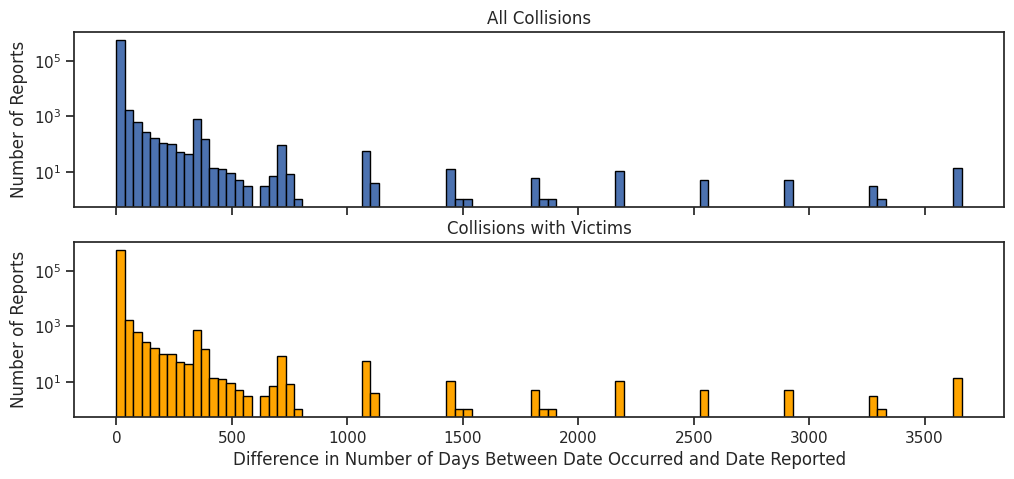

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_style("ticks")

figure, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(12,5))
ax[0].hist(dat["reported_occurred_diff_int"],bins=100, edgecolor="black")
ax[0].set_yscale("log")
ax[0].set_ylabel("Number of Reports")
ax[0].set_title("All Collisions")
ax[0].grid(False)

ax[1].hist(dat[dat["victim"]]["reported_occurred_diff_int"],bins=100, edgecolor="black", color="orange")
ax[1].set_yscale("log")
ax[1].set_ylabel("Number of Reports")
ax[1].set_title("Collisions with Victims")
ax[1].set_xlabel("Difference in Number of Days Between Date Occurred and Date Reported")
ax[1].grid(False)

The DMV indicates that a report should be filed within 10 days if there were over $1,000 in property damage or someone was injured. About 2\% did not report within 10 days and 740 collisions which took more than a year to report. Additionally, if there were victims, I would expect the victims or the victims' families to report it earlier, but there was a similar pattern when there were victims and were not. Hence, I **made an assumption that these were transcription typos and that I would use the `date_occcurred` column for the analysis.**

In [ ]:
(dat["reported_occurred_diff_int"]>=10).sum()/(dat["reported_occurred_diff_int"]).count()

0.022639077601232287

In [ ]:
(dat["reported_occurred_diff_int"]>365).sum()

740

### Location (areas)

According to the data dictionary, the `area_id` and `area_name` are "The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles." As expected, I see that there is a 1:1 match from  `area_id` to `area_name`.

In [ ]:
dat[["area_id","area_name"]].value_counts().sort_index()

,,count
area_id,area_name,
1,Central,23510
2,Rampart,21589
3,Southwest,33735
4,Hollenbeck,20820
5,Harbor,21573
6,Hollywood,27599
7,Wilshire,32253
8,West LA,30039
9,Van Nuys,28473


### Location (Reporting District)

The reporting district is "A code used in producing reports to group data into geographic sub-areas within an area. Find LAPD Reporting Districts on the [LA City GeoHub](http://geohub.lacity.org/datasets/c4f83909b81d4786aa8ba8a74a4b4db1_4)." They are used for organizing crimes into specific areas when reporting crime.

I downloaded the reporting district data from the [LA City Geohub](https://geohub.lacity.org/datasets/lahub::lapd-reporting-district/about).

In [ ]:
dat["reporting_district"].value_counts().sort_index()

,count
reporting_district,
100,4
101,453
105,217
109,23
111,2239
...,...
2189,827
2196,151
2197,57


In [ ]:
dfrd = pd.read_csv('LAPD_Reporting_Districts.csv')

In [ ]:
dfrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135 entries, 0 to 1134
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FID           1135 non-null   int64  
 1   REPDIST       1135 non-null   int64  
 2   PREC          1135 non-null   int64  
 3   APREC         1135 non-null   object 
 4   BUREAU        1135 non-null   object 
 5   BASICCAR      1135 non-null   object 
 6   AREA          1135 non-null   float64
 7   PERIMETER     1135 non-null   float64
 8   SHAPE_Length  1135 non-null   float64
 9   SHAPE_Area    1135 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 88.8+ KB


In [ ]:
dfrd.head()

,FID,REPDIST,PREC,APREC,BUREAU,BASICCAR,AREA,PERIMETER,SHAPE_Length,SHAPE_Area
0,1,1901,19,MISSION,VALLEY BUREAU,19A1,4.367178e+07,31946.355664,0.099163,0.000397
1,2,1705,17,DEVONSHIRE,VALLEY BUREAU,17A35,1.098543e+08,48888.592747,0.148847,0.001000
2,3,1902,19,MISSION,VALLEY BUREAU,19A7,3.353075e+07,26849.358596,0.081961,0.000305
3,4,1903,19,MISSION,VALLEY BUREAU,19A7,1.082610e+07,14488.784549,0.045659,0.000099
4,5,1904,19,MISSION,VALLEY BUREAU,19A7,1.730524e+07,20025.544413,0.061883,0.000157


In [ ]:
dfrd["REPDIST"].value_counts().sort_index()

,count
REPDIST,
101,1
105,1
109,1
111,1
112,1
...,...
2189,1
2196,1
2197,1


In [ ]:
dfrd["REPDIST"].value_counts()

,count
REPDIST,
1901,1
319,1
305,1
307,1
892,1
...,...
998,1
1105,1
991,1


`REPDIST` in this new data frame is also unique so it seems suitable that I use the `REPDIST` column as the foreign key in order to merge the data. I find that they are both numeric columns and judging by their abbreviation, should be the same item.

Thus, I needed to see if there are any reporting districts in the original data frame which aren't found in this reporting district data.

In [ ]:
dat[~dat["reporting_district"].isin(dfrd["REPDIST"])]["reporting_district"].value_counts()

,count
reporting_district,
665,617
1800,112
1942,110
1400,98
500,56
...,...
609,1
696,1
1564,1


There are 197 reporting districts which aren't in the new reporting district data I found. There also does not seem to be an even distribution of vehicle collisions in those reporting districts that are not found. Thus, I can use the reporting district columns, but if I do, I will be interpreting the results with caution.

In [ ]:
dfrd.columns = ["rd_"+ col.lower() for col in dfrd.columns]
dfrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135 entries, 0 to 1134
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rd_fid           1135 non-null   int64  
 1   rd_repdist       1135 non-null   int64  
 2   rd_prec          1135 non-null   int64  
 3   rd_aprec         1135 non-null   object 
 4   rd_bureau        1135 non-null   object 
 5   rd_basiccar      1135 non-null   object 
 6   rd_area          1135 non-null   float64
 7   rd_perimeter     1135 non-null   float64
 8   rd_shape_length  1135 non-null   float64
 9   rd_shape_area    1135 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 88.8+ KB


In [ ]:
df_rd = pd.merge(dat, dfrd, how="left", left_on="reporting_district", right_on="rd_repdist")

In [ ]:
df_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572594 entries, 0 to 572593
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   dr_number                   572594 non-null  int64         
 1   date_reported               572594 non-null  object        
 2   date_occurred               572594 non-null  object        
 3   time_occurred               572594 non-null  object        
 4   area_id                     572594 non-null  int64         
 5   area_name                   572594 non-null  object        
 6   reporting_district          572594 non-null  int64         
 7   crime_code                  572594 non-null  int64         
 8   crime_code_description      572594 non-null  object        
 9   mo_codes                    485596 non-null  object        
 10  victim_age                  489109 non-null  float64       
 11  victim_sex                  563393 non-

In [ ]:
df_rd[df_rd["rd_repdist"].isna()]["reporting_district"].value_counts()

,count
reporting_district,
665,617
1800,112
1942,110
1400,98
500,56
...,...
609,1
696,1
1564,1


### Location (Premise)

Now, checking  by `premise_code` and `premise_description`.
* There is a 1:1 match except for `premise_code` 418 which has no description. When I examine the location by longitude and latitude coordinates, I find that other `premise_code`s in the same location are "street", "alley", and "parking lot".
* Most collisions occur on streets, parking lots, and sidewalks. There is a factor of 10 difference among the top 3.

In [ ]:
df_rd[["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,545362
108.0,PARKING LOT,18062
102.0,SIDEWALK,3108
103.0,ALLEY,1022
104.0,DRIVEWAY,986
...,...,...
405.0,CLOTHING STORE,1
407.0,HARDWARE/BUILDING SUPPLY,1
408.0,AUTO SUPPLY STORE*,1


In [ ]:
df_rd["premise_code"].value_counts()

,count
premise_code,
101.0,545362
108.0,18062
102.0,3108
103.0,1022
104.0,986
...,...
706.0,1
405.0,1
251.0,1


In [ ]:
df_rd["premise_description"].value_counts()

,count
premise_description,
STREET,545362
PARKING LOT,18062
SIDEWALK,3108
ALLEY,1022
DRIVEWAY,986
...,...
AUTO SUPPLY STORE*,1
BOWLING ALLEY*,1
REDLINE SUBWAY PLATFORM,1


In [ ]:
df_rd[(~df_rd["premise_code"].isna()) & (df_rd["premise_description"].isna())]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area
47574,201213728,05/28/2020,05/28/2020,12:40,12,77th Street,1256,997,TRAFFIC COLLISION,1402,19.0,X,X,418.0,NaN,600 W FLORENCE AV,NaN,"(33.9747, -118.2838)",2020-05-28 12:40:00,2020-05-28,True,0:00:00,0,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052


In [ ]:
df_rd[df_rd["location"]=="(33.9747, -118.2838)"][["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,51
108.0,PARKING LOT,4
103.0,ALLEY,2


In [ ]:
df_rd[df_rd["location"]=="(33.9747, -118.2838)"]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area
7835,201210862,04/13/2020,04/13/2020,19:15,12,77th Street,1249,997,TRAFFIC COLLISION,4012 3037 3004 3028 3030 3101,45.0,F,H,NaN,NaN,00,NaN,"(33.9747, -118.2838)",2020-04-13 19:15:00,2020-04-13,True,0:00:00,0,915.0,1249.0,12.0,77TH STREET,SOUTH BUREAU,12A49,5.989014e+06,10159.599780,0.030060,0.000054
9462,191222846,09/02/2019,09/01/2019,13:30,12,77th Street,1256,997,TRAFFIC COLLISION,0605,31.0,F,H,101.0,STREET,FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2019-09-01 13:30:00,2019-09-02,True,"1 day, 0:00:00",1,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052
19166,201218671,07/26/2020,07/25/2020,09:40,12,77th Street,1256,997,TRAFFIC COLLISION,NaN,28.0,M,H,101.0,STREET,W FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2020-07-25 09:40:00,2020-07-26,True,"1 day, 0:00:00",1,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052
33160,191228863,12/13/2019,12/13/2019,01:30,12,77th Street,1256,997,TRAFFIC COLLISION,4012 3036 3006 3028 3101 0605,30.0,M,B,101.0,STREET,FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2019-12-13 01:30:00,2019-12-13,True,0:00:00,0,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052
47287,201209542,03/22/2020,03/22/2020,15:15,12,77th Street,1249,997,TRAFFIC COLLISION,4025 3036 3004 3028 3030 3101,52.0,F,B,101.0,STREET,FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2020-03-22 15:15:00,2020-03-22,True,0:00:00,0,915.0,1249.0,12.0,77TH STREET,SOUTH BUREAU,12A49,5.989014e+06,10159.599780,0.030060,0.000054
47574,201213728,05/28/2020,05/28/2020,12:40,12,77th Street,1256,997,TRAFFIC COLLISION,1402,19.0,X,X,418.0,NaN,600 W FLORENCE AV,NaN,"(33.9747, -118.2838)",2020-05-28 12:40:00,2020-05-28,True,0:00:00,0,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052
50069,201214087,06/04/2020,05/29/2020,13:05,12,77th Street,1249,997,TRAFFIC COLLISION,NaN,42.0,M,H,101.0,STREET,DENVER,FLORENCE,"(33.9747, -118.2838)",2020-05-29 13:05:00,2020-06-04,True,"6 days, 0:00:00",6,915.0,1249.0,12.0,77TH STREET,SOUTH BUREAU,12A49,5.989014e+06,10159.599780,0.030060,0.000054
67665,191213520,05/14/2019,05/13/2019,17:10,12,77th Street,1249,997,TRAFFIC COLLISION,4025 3004 3026 3029 3101,42.0,M,O,101.0,STREET,FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2019-05-13 17:10:00,2019-05-14,True,"1 day, 0:00:00",1,915.0,1249.0,12.0,77TH STREET,SOUTH BUREAU,12A49,5.989014e+06,10159.599780,0.030060,0.000054
79189,191221222,08/25/2019,08/25/2019,16:00,12,77th Street,1256,997,TRAFFIC COLLISION,4025 3037 3004 3026 3034 3101,24.0,M,H,101.0,STREET,FLORENCE AV,DENVER AV,"(33.9747, -118.2838)",2019-08-25 16:00:00,2019-08-25,True,0:00:00,0,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052
104451,101207764,02/19/2010,02/19/2010,10:40,12,77th Street,1256,997,TRAFFIC COLLISION,NaN,25.0,F,H,101.0,STREET,DENVER,FLORENCE,"(33.9747, -118.2838)",2010-02-19 10:40:00,2010-02-19,True,0:00:00,0,932.0,1256.0,12.0,77TH STREET,SOUTH BUREAU,12A57,5.732625e+06,10915.327085,0.034439,0.000052


### Address (Misc)

Now, checking  by `address`, `cross_street`, and `location`.
   * `address` has the street name (and occasionally the number). There is an address for every record. I cleaned up the white space.
   * `cross_street` has 27,280 records without a cross street. There are no corresponding records where there is an address found when there isn't a cross street. I cleaned up the white space.
   * For `location`, there are 770 records with a location of (0.0, 0.0). At first glance, these look like they occur less often in `area_id` 4. The rest look within reason and there is a location for every row. **Thus, I replaced the 770 (0,0) records with NA under the assumption that the location is invalid/non-reported.** I separated so that there is a latitude and longitude column.

In [ ]:
df_rd["address"].value_counts(dropna=False)

,count
address,
WESTERN AV,7660
VENTURA BL,6859
SHERMAN WY,6819
SEPULVEDA BL,6478
VERMONT AV,6242
...,...
JENNY ST,1
REEF MALL,1
HINDRY ST,1


In [ ]:
df_rd["address"].value_counts(dropna=False).sort_index()

,count
address,
0 ST,1
00,934
00 20TH AV,1
00 ANAHEIM ST,1
00 ANCHORAGE ST,1
...,...
ZONAL ST,4
ZOO,24
ZOO DR,95


In [ ]:
sum(df_rd["address"].isna())

0

In [ ]:
df_rd["address_clean"] = df_rd["address"].replace(r'\s+',' ', regex=True)
df_rd["address_clean"].value_counts(dropna=False).sort_index()

,count
address_clean,
0 ST,1
00,934
00 20TH AV,1
00 ANAHEIM ST,1
00 ANCHORAGE ST,1
...,...
ZONAL ST,4
ZOO,24
ZOO DR,95


In [ ]:
df_rd["cross_street"].value_counts(dropna=False)

,count
cross_street,
NaN,27280
VERMONT AV,4237
FIGUEROA ST,4067
WESTERN AV,4002
SHERMAN WY,3405
...,...
CRESCENT PAR,1
HARBOR ST,1
105,1


In [ ]:
df_rd[df_rd["location"].isin(df_rd[df_rd["cross_street"].isna()][["location"]])]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean


In [ ]:
df_rd[df_rd["address"].isin(df_rd[df_rd["cross_street"].isna()][["address"]])]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean


In [ ]:
df_rd["cross_street_clean"] = df_rd["cross_street"].replace(r'\s+',' ', regex=True)
df_rd["cross_street_clean"].value_counts(dropna=False).sort_index()

,count
cross_street_clean,
1 ST,4
1 ST ST,2
10,3
10 AV,1
10 EAST,1
...,...
ZOO DR,97
ZORADA CT,1
ZORADA DR,1


In [ ]:
df_rd["location"].value_counts(dropna=False).sort_index()

,count
location,
"(0.0, 0.0)",770
"(33.3427, -118.3258)",2
"(33.7065, -118.2879)",1
"(33.7065, -118.2928)",20
"(33.7065, -118.2929)",3
...,...
"(34.3797, -118.5286)",1
"(34.5957, -118.1784)",5
"(34.6012, -118.1605)",1


In [ ]:
sum(df_rd["location"].isnull())

0

In [ ]:
df_rd[df_rd["location"]=="(0.0, 0.0)"]["area_id"].value_counts().sort_index()

,count
area_id,
1,18
2,9
3,34
4,9
5,23
6,17
7,29
8,50
9,52


In [ ]:
df_rd["area_id"].value_counts().sort_index()

,count
area_id,
1,23510
2,21589
3,33735
4,20820
5,21573
6,27599
7,32253
8,30039
9,28473


In [ ]:
df_rd["location_clean"] = df_rd["location"].replace('(0.0, 0.0)', np.nan)
df_rd["location_clean"].value_counts(dropna=False).sort_index()

,count
location_clean,
"(33.3427, -118.3258)",2
"(33.7065, -118.2879)",1
"(33.7065, -118.2928)",20
"(33.7065, -118.2929)",3
"(33.7067, -118.2879)",4
...,...
"(34.5957, -118.1784)",5
"(34.6012, -118.1605)",1
"(34.6903, -118.3053)",1


In [ ]:
df_rd[["latitude", "longitude"]] = df_rd["location_clean"].str.split(",", expand=True)
# df_rd["latitude"]
df_rd["latitude"] = df_rd["latitude"].str.replace("(","", regex=False)
df_rd["longitude"] = df_rd["longitude"].str.replace(")","", regex=False)

df_rd["latitude"] = pd.to_numeric(df_rd["latitude"])
df_rd["longitude"] = pd.to_numeric(df_rd["longitude"])

df_rd.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182


### Crime code and description
Now, I need to check the `crime_code` and `crime_code_description`. I find that they are all 997 and "TRAFFIC COLLISION" respectively. This matches the data dictionary and I can assume that this is the filter that was applied to generate this dataset.

In [ ]:
df_rd["crime_code"].value_counts()

,count
crime_code,
997,572594


In [ ]:
df_rd["crime_code_description"].value_counts()

,count
crime_code_description,
TRAFFIC COLLISION,572594


Because these columns do not provide any useful information to the analysis, I decided to drop them.

In [ ]:
df_rd.drop(columns=["crime_code","crime_code_description"], inplace=True)
df_rd.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182


### Victim Information

Now, checking  by `victim_age`, `victim_sex`, and `victim_descent` if one exists based on my prior assumptions of one victim per collision and that at least one of the victim columns is filled out.
   * Looking at `victim_age`, there are 7,400 where they are 99 years old. and there are 83,485 where they have null values. The `victim_age` has a character limit of two-characters. It is possible for a victim to be over 100 years old, but very few people live to be over 100 years old. Due to the distribution, I will **assume that 99 is a catch-all code.**
   * Regarding `victim_sex`, according to the data dictionary, F=Female, M=Male, X=Other/Unknown. I do not know what H and N correspond to though **so I will assume it is a typo and will re-code them as "Other/Unknown"**. There are also 9,201 null values.
   * For `victim_descent`, there are 2 "-" which I **assume is a miscoding and therefore will recode as "X: Unknown"** and 10,098 null values. The rest match the data dictionary.

**Victim Age**

In [ ]:
df_rd[(df_rd["victim_age"].isna()) & (df_rd["victim_sex"].isna()) & (df_rd["victim_descent"].isna())]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude
298,191613359,08/31/2019,08/30/2019,22:20,16,Foothill,1653,3037 3011 3024 3034 3101 3401 3701 4026,NaN,NaN,NaN,101.0,STREET,MONTAGUE ST,SAN FERNANDO RD,"(34.2512, -118.4063)",2019-08-30 22:20:00,2019-08-31,False,"1 day, 0:00:00",1,110.0,1653.0,16.0,FOOTHILL,VALLEY BUREAU,16A23,1.206978e+07,14232.469967,0.043173,0.000110,MONTAGUE ST,SAN FERNANDO RD,"(34.2512, -118.4063)",34.2512,-118.4063
841,191715008,09/07/2019,09/07/2019,11:00,17,Devonshire,1701,NaN,NaN,NaN,NaN,108.0,PARKING LOT,RINALDI ST,CORBIN AV,"(34.2748, -118.5621)",2019-09-07 11:00:00,2019-09-07,False,0:00:00,0,21.0,1701.0,17.0,DEVONSHIRE,VALLEY BUREAU,17A23,9.811502e+07,47488.979227,0.145497,0.000893,RINALDI ST,CORBIN AV,"(34.2748, -118.5621)",34.2748,-118.5621
2103,201409246,04/03/2020,04/03/2020,20:50,14,Pacific,1496,3011 3028 3034 3037 3101 3401 3701 4014,NaN,NaN,NaN,NaN,NaN,00,NaN,"(33.9474, -118.3961)",2020-04-03 20:50:00,2020-04-03,False,0:00:00,0,970.0,1496.0,14.0,PACIFIC,WEST BUREAU,14A67,3.821328e+06,8810.972220,0.027594,0.000035,00,NaN,"(33.9474, -118.3961)",33.9474,-118.3961
2199,201707954,04/05/2020,04/05/2020,05:00,17,Devonshire,1777,3011 3027 3037 3101 4026,NaN,NaN,NaN,101.0,STREET,NORDHOFF ST,GOTHIC AV,"(34.2357, -118.4895)",2020-04-05 05:00:00,2020-04-05,False,0:00:00,0,128.0,1777.0,17.0,DEVONSHIRE,VALLEY BUREAU,17A95,1.431905e+07,16189.022322,0.047816,0.000130,NORDHOFF ST,GOTHIC AV,"(34.2357, -118.4895)",34.2357,-118.4895
2999,140920716,12/24/2014,12/24/2014,04:44,9,Van Nuys,943,3011 3030 3028 3101 3401 3701 4009,NaN,NaN,NaN,101.0,STREET,5600 VAN NUYS BL,NaN,"(34.1721, -118.4485)",2014-12-24 04:44:00,2014-12-24,False,0:00:00,0,311.0,943.0,9.0,VAN NUYS,VALLEY BUREAU,9A41,1.138858e+07,13665.741465,0.040382,0.000103,5600 VAN NUYS BL,NaN,"(34.1721, -118.4485)",34.1721,-118.4485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566833,211819687,11/08/2021,11/08/2021,00:25,18,Southeast,1842,3006 3028 3039 4018,NaN,NaN,NaN,101.0,STREET,111TH ST,SAN PEDRO ST,"(33.9348, -118.2695)",2021-11-08 00:25:00,2021-11-08,False,0:00:00,0,981.0,1842.0,18.0,SOUTHEAST,SOUTH BUREAU,18A41,1.047392e+07,13164.857860,0.040525,0.000095,111TH ST,SAN PEDRO ST,"(33.9348, -118.2695)",33.9348,-118.2695
568220,210217532,11/14/2021,11/14/2021,17:00,2,Rampart,266,3033 0605 3003 3024 3035 3037 3602 3101 4024 3401,NaN,NaN,NaN,101.0,STREET,JAMES M WOOD BL,BONNIE BRAE ST,"(34.0524, -118.2766)",2021-11-14 17:00:00,2021-11-14,False,0:00:00,0,648.0,266.0,2.0,RAMPART,CENTRAL BUREAU,2A75,1.486879e+06,4883.112427,0.014780,0.000013,JAMES M WOOD BL,BONNIE BRAE ST,"(34.0524, -118.2766)",34.0524,-118.2766
570549,212018870,12/30/2021,12/29/2021,18:50,20,Olympic,2034,3006 3028 3039 4027,NaN,NaN,NaN,108.0,PARKING LOT,8TH ST,ARDMORE AV,"(34.0577, -118.302)",2021-12-29 18:50:00,2021-12-30,False,"1 day, 0:00:00",1,619.0,2034.0,20.0,OLYMPIC,WEST BUREAU,20A33,1.735182e+06,5784.417516,0.017494,0.000016,8TH ST,ARDMORE AV,"(34.0577, -118.302)",34.0577,-118.3020
571596,221004529,01/16/2022,01/16/2022,17:25,10,West Valley,1049,3011 3034 3026 3039 3037 3101 4026,NaN,NaN,NaN,101.0,STREET,BURBANK BL,BALBOA BL,"(34.1722, -118.501)",2022-01-16 17:25:00,2022-01-16,False,0:00:00,0,292.0,1049.0,10.0,WEST VALLEY,VALLEY BUREAU,10A17,7.280605e+07,35090.681340,0.106492,0.000661,BURBANK BL,BALBOA BL,"(34.1722, -118.501)",34.1722,-118.5010


In [ ]:
df_rd[(df_rd["victim_age"].notna()) | (df_rd["victim_sex"].notna()) | (df_rd["victim_descent"].notna())].shape

(566250, 36)

In [ ]:
# Victim age
print('Number of victim_age rows with NA:', sum(df_rd["victim_age"].isna()))
df_rd["victim_age"].value_counts().sort_index()

Number of victim_age rows with NA: 83485


,count
victim_age,
10.0,56
11.0,48
12.0,67
13.0,75
14.0,113
...,...
95.0,55
96.0,45
97.0,34


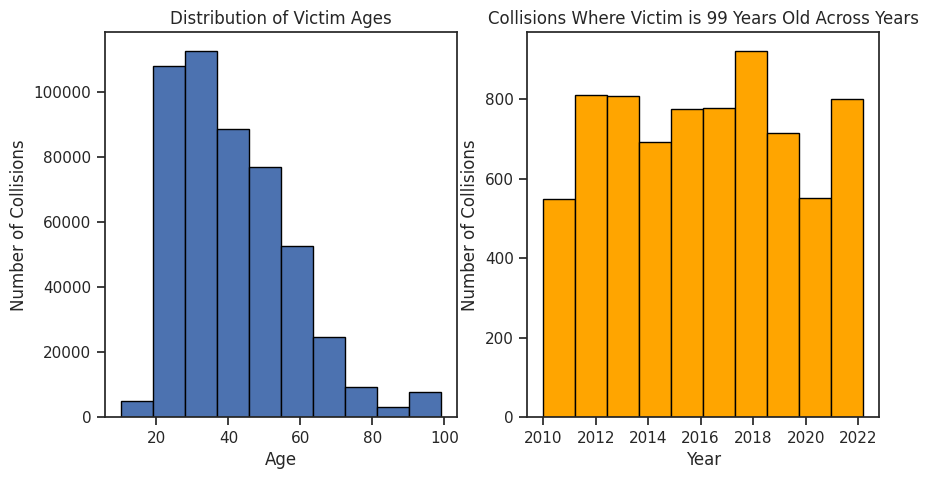

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_style("ticks")

figure, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,5))
ax[0].hist(df_rd["victim_age"],bins=10, edgecolor="black")
ax[0].set_ylabel("Number of Collisions")
ax[0].set_xlabel("Age")
ax[0].set_title("Distribution of Victim Ages")
ax[0].grid(False)

ax[1].hist(df_rd[df_rd["victim_age"]==99]["dttm_occurred"],bins=10, edgecolor="black", color="orange")
ax[1].set_ylabel("Number of Collisions")
ax[1].set_title("Collisions Where Victim is 99 Years Old Across Years")
ax[1].set_xlabel("Year")
ax[1].grid(False)

plt.show()

**Victim Sex**

In [ ]:
print('Number of victim_sex rows with NA:', sum(df_rd["victim_sex"].isna()))
df_rd["victim_sex"].value_counts(dropna=False).sort_index()

Number of victim_sex rows with NA: 9201


,count
victim_sex,
F,212946
H,156
M,334517
N,11
X,15763
NaN,9201


In [ ]:
sexdict = dict(F="Female", M="Male", X="Other/Unknown", H="Other/Unknown", N="Other/Unknown")
df_rd['victim_sex_clean'] = df_rd.victim_sex.replace(sexdict)
df_rd.victim_sex_clean.value_counts(dropna=False).sort_index()

,count
victim_sex_clean,
Female,212946
Male,334517
Other/Unknown,15930
NaN,9201


**Victim Descent**

In [ ]:
print("Number of null victim descents:", df_rd["victim_descent"].isna().sum())
df_rd["victim_descent"].value_counts().sort_index()

Number of null victim descents: 10098


,count
victim_descent,
-,2
A,20791
B,75824
C,864
D,17
F,1696
G,47
H,214080
I,178


Additionally, Asians and Native Hawaiian and Pacific Islanders had more specific descent groups. In order to make it more comparable, I decided to use the groupings the US Census uses: White, Black, American Indian/Alaska Native, Asian, Native Hawaiian or Pacific Islander, and other.

Unfortunately, this means I am still comparing race and ethnicity which are not the same.

In [ ]:
# Decode victim descent
descent_dict = {"A":"Other Asian",
                "B":"Black",
                "C":"Chinese",
                "D":"Cambodian",
                "F":"Filipino",
                "G":"Guamanian",
                "H":"Hispanic/Latin/Mexican",
                "I":"American Indian/Alaskan Native",
                "J":"Japanese",
                "K":"Korean",
                "L":"Laotian",
                "O":"Other",
                "P":"Pacific Islander",
                "S":"Samoan",
                "U":"Hawaiian",
                "V":"Vietnamese",
                "W":"White",
                "X":"Unknown",
                "Z":"Asian Indian",
                "-":"Unknown"}
descent_dict2 = {"A":"Asian", #Other Asian
                "B":"Black",
                "C":"Asian", #Chinese
                "D":"Asian", #Cambodian
                "F":"Native Hawaiian/Pacific Islander", #Filipino
                "G":"Native Hawaiian/Pacific Islander", #Guamanian
                "H":"Hispanic/Latin/Mexican",
                "I":"American Indian/Alaskan Native",
                "J":"Asian", #Japanese
                "K":"Asian", #Korean
                "L":"Asian", #Laotian
                "O":"Other",
                "P":"Native Hawaiian/Pacific Islander", #Pacific Islander
                "S":"Native Hawaiian/Pacific Islander", #Samoan
                "U":"Native Hawaiian/Pacific Islander", #Hawaiian
                "V":"Asian", #Vietnamese
                "W":"White",
                "X":"Unknown",
                "Z":"Asian", #Asian Indian
                "-":"Unknown"}
df_rd['victim_descent_clean'] = df_rd.victim_descent.replace(descent_dict2)
df_rd['victim_descent_clean'].value_counts(dropna=False).sort_index()

,count
victim_descent_clean,
American Indian/Alaskan Native,178
Asian,26832
Black,75824
Hispanic/Latin/Mexican,214080
Native Hawaiian/Pacific Islander,2384
Other,82656
Unknown,28126
White,132416
NaN,10098


### MO Codes

Now, checking the `mo_codes`. Since there are multiple MO codes in the same column, I created a separate copy of the data frame so I can examine the MO codes by themselves without changing the original dataset too much.

There are 7 MO codes that do not have a corresponding definition, for a total of 841 appearances of MO Codes without a definition. **I will assume these were mistyped or mistranscribed. I will move forward by recoding the MO code as NaN.**

In [ ]:
df_rd_copy = deepcopy(df_rd)
df_rd_copy[["mo_code_0",
            "mo_code_1",
            "mo_code_2",
            "mo_code_3",
            "mo_code_4",
            "mo_code_5",
            "mo_code_6",
            "mo_code_7",
            "mo_code_8",
            "mo_code_9"]] = df_rd_copy["mo_codes"].str.split(" ", expand=True)

df_rd_copy.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude,victim_sex_clean,victim_descent_clean,mo_code_0,mo_code_1,mo_code_2,mo_code_3,mo_code_4,mo_code_5,mo_code_6,mo_code_7,mo_code_8,mo_code_9
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002,Male,Hispanic/Latin/Mexican,3036,3004,3026,3101,4003,None,None,None,None,None
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089,Female,Hispanic/Latin/Mexican,3037,3006,3028,3030,3039,3101,4003,None,None,None
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078,Male,Unknown,3101,3401,3701,3006,3030,None,None,None,None,None
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391,Male,Hispanic/Latin/Mexican,0605,3101,3401,3701,3011,3034,None,None,None,None
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182,Male,Black,0605,4025,3037,3004,3025,3101,None,None,None,None


In [ ]:
dfrd_mo_long = pd.melt(df_rd_copy, id_vars=["dr_number"], value_vars = ["mo_code_0",
                                                                        "mo_code_1",
                                                                        "mo_code_2",
                                                                        "mo_code_3",
                                                                        "mo_code_4",
                                                                        "mo_code_5",
                                                                        "mo_code_6",
                                                                        "mo_code_7",
                                                                        "mo_code_8",
                                                                        "mo_code_9",])
dfrd_mo_long.columns = ["dr_number","orig_var","mo_code"]
dfrd_mo_long.mo_code.value_counts() # 333 mo_codes, max is 3101 with 419,587

,count
mo_code,
3101,419587
3401,342184
3701,342124
3004,248261
3037,225631
...,...
1306,1
0511,1
1024,1


In [ ]:
# check what happens to the "None" values when they are melted.
# 190319651 only has 3036, 3004, 3026, 3101, 4003
dfrd_mo_long[dfrd_mo_long.dr_number==190319651]
dfrd_mo_long.dropna(subset=["mo_code"], inplace=True)
dfrd_mo_long.shape #3182316

dfrd_mo_long[["dr_number","mo_code"]].value_counts() #there are unique dr_numbers to mo_codes.

dr_number  mo_code
100101322  1402       1
180809040  3037       1
180809017  4027       1
180809023  3006       1
           3028       1
                     ..
151312453  3008       1
           3025       1
           3101       1
           3401       1
222106942  4026       1
Name: count, Length: 3182316, dtype: int64

I checked if every `mo_code` found in the dataset exists in the mo_code_dictionary but I found that not all of them exist in the dictionary.

In [ ]:
dfrd_mo_desc = pd.merge(dfrd_mo_long,
                        mo_codes_dict,
                        left_on="mo_code",
                        right_on="mo_code",
                        how="left")
dfrd_mo_desc.shape
dfrd_mo_desc

,dr_number,orig_var,mo_code,code_def
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes
1,190319680,mo_code_0,3037,T/C - At Intersection - No
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident
...,...,...,...,...
3182311,221306137,mo_code_9,4024,T/C - Central Traffic (CTD)
3182312,221105702,mo_code_9,3033,T/C - Private Property - No
3182313,221306205,mo_code_9,4024,T/C - Central Traffic (CTD)
3182314,220205789,mo_code_9,4002,T/C - Rampart


In [ ]:
dfrd_mo_desc[["mo_code","code_def"]].value_counts()

,,count
mo_code,code_def,
3101,T/C - PCF (A) In the Narrative,419587
3401,T/C - Type of Collision,342184
3701,T/C - Movement Preceding Collision,342124
3004,T/C - Veh vs Veh,248261
3037,T/C - At Intersection - No,225631
...,...,...
1014,Game,1
0511,Masochism/bondage,1
0515,"Put hand, finger or object into vagina",1


In [ ]:
print(f'Number of MO Codes without a description: {dfrd_mo_desc["code_def"].isnull().sum()}') #841 are NaN values.
print("")
dfrd_mo_desc[dfrd_mo_desc["code_def"].isnull()]["mo_code"].value_counts()

Number of MO Codes without a description: 841



,count
mo_code,
0947,731
3031,71
3063,20
3064,16
1505,1
2053,1
1528,1


In [ ]:
null_mo = dfrd_mo_desc[dfrd_mo_desc["code_def"].isnull()]["mo_code"].unique()
dfrd_mo_desc['mo_code_clean'] = np.where(dfrd_mo_desc['mo_code'].isin(null_mo),np.nan,dfrd_mo_desc['mo_code'])

In [ ]:
dfrd_mo_desc['mo_code_clean'].value_counts()

,count
mo_code_clean,
3101,419587
3401,342184
3701,342124
3004,248261
3037,225631
...,...
0405,1
0446,1
1214,1


In [ ]:
dfrd_mo_desc['mo_code_clean'].isin(null_mo).value_counts()

,count
mo_code_clean,
False,3182316


In [ ]:
dfrd_mo_desc.dropna(subset=["mo_code_clean"])

,dr_number,orig_var,mo_code,code_def,mo_code_clean
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
...,...,...,...,...,...
3182311,221306137,mo_code_9,4024,T/C - Central Traffic (CTD),4024
3182312,221105702,mo_code_9,3033,T/C - Private Property - No,3033
3182313,221306205,mo_code_9,4024,T/C - Central Traffic (CTD),4024
3182314,220205789,mo_code_9,4002,T/C - Rampart,4002


I decided to filter out the 2022 data to make comparisons across complete years, months, and dates.

In [ ]:
#filtering out 2022 data
dfin = df_rd[df_rd["date_reported_dt"].dt.year!=2022]

print(f'Min of Date Occurred: {dfin["date_occurred"].min()}')
print(f'Max of Date Occurred: {dfin["date_occurred"].max()}')
print("")
print(f'Min of Date Reported: {dfin["date_occurred"].min()}')
print(f'Max of Date Reported: {dfin["date_occurred"].max()}')

Min of Date Occurred: 01/01/2010
Max of Date Occurred: 12/31/2021

Min of Date Reported: 01/01/2010
Max of Date Reported: 12/31/2021


In [ ]:
mo_fin = dfrd_mo_desc[dfrd_mo_desc["dr_number"].isin(dfin["dr_number"])]
mo_fin

,dr_number,orig_var,mo_code,code_def,mo_code_clean
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
...,...,...,...,...,...
3182135,181616582,mo_code_9,3602,T/C - Unlicensed motorist,3602
3182136,191917533,mo_code_9,4026,T/C - Valley Traffic (VTD),4026
3182137,191917534,mo_code_9,3401,T/C - Type of Collision,3401
3182199,211321028,mo_code_9,3401,T/C - Type of Collision,3401


# Final Dataset
I am now left with the final dataframes: `dfin` and `dfrd_mo_desc`.

In [ ]:
print("Shape:", dfin.shape)
dfin.head()

Shape: (569291, 38)


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude,victim_sex_clean,victim_descent_clean
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002,Male,Hispanic/Latin/Mexican
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089,Female,Hispanic/Latin/Mexican
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078,Male,Unknown
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391,Male,Hispanic/Latin/Mexican
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182,Male,Black


In [ ]:
dfin.dr_number.value_counts()

,count
dr_number,
190319651,1
160911640,1
160909706,1
160905467,1
160909995,1
...,...
121011241,1
121007805,1
121006775,1


In [ ]:
dfin.to_pickle('LA_Traffic_Collisions_dfin_1.pkl')

In [ ]:
print("Shape:", mo_fin.shape)
mo_fin.head()

Shape: (3160710, 5)


,dr_number,orig_var,mo_code,code_def,mo_code_clean
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605


In [ ]:
mo_fin.to_pickle('LA_Traffic_Collisions_mo_fin_1.pkl')

As I want to examine the effects of Vision Zero, I created two additional data frames off of these initital data frames: pre-Vision Zero (before Aug 24, 2015) and post-Vision Zero (the day of and after Aug 24, 2015).

In [ ]:
dfin_p2015 = dfin[dfin.dttm_occurred.dt.date<datetime.date(2015,8,24)]
dfin_2015p = dfin[dfin.dttm_occurred.dt.date>=datetime.date(2015,8,24)]